In [1]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for nicer plots
sns.set(style="whitegrid")

# Display all columns when printing DataFrame
pd.set_option("display.max_columns", None)

# Step 2: Download KOI cumulative table from NASA Exoplanet Archive
url = (
    "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?"
    "query=select+kepoi_name,koi_disposition,koi_period,koi_duration,koi_depth,"
    "koi_prad,koi_steff,koi_srad,koi_slogg,koi_smet,koi_model_snr+"
    "from+cumulative&format=csv"
)

# Read into DataFrame
df = pd.read_csv(url)

# Step 3: Save to file (optional)
df.to_csv("koi_cumulative_2025_snapshot.csv", index=False)

# Step 4: Preview dataset
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (9564, 11)


,kepoi_name,koi_disposition,koi_period,koi_duration,koi_depth,koi_prad,koi_steff,koi_srad,koi_slogg,koi_smet,koi_model_snr
0,K00752.01,CONFIRMED,9.488036,2.95750,615.8,2.26,5455.0,0.927,4.467,0.14,35.8
1,K00752.02,CONFIRMED,54.418383,4.50700,874.8,2.83,5455.0,0.927,4.467,0.14,25.8
2,K00753.01,CANDIDATE,19.899140,1.78220,10829.0,14.60,5853.0,0.868,4.544,-0.18,76.3
3,K00754.01,FALSE POSITIVE,1.736952,2.40641,8079.2,33.46,5805.0,0.791,4.564,-0.52,505.6
4,K00755.01,CONFIRMED,2.525592,1.65450,603.3,2.75,6031.0,1.046,4.438,0.07,40.9


Before dropping NaNs: (9564, 12)
After dropping NaNs: (9178, 12)

✅ Label distribution:
label
1    4616
0    4562
Name: count, dtype: int64


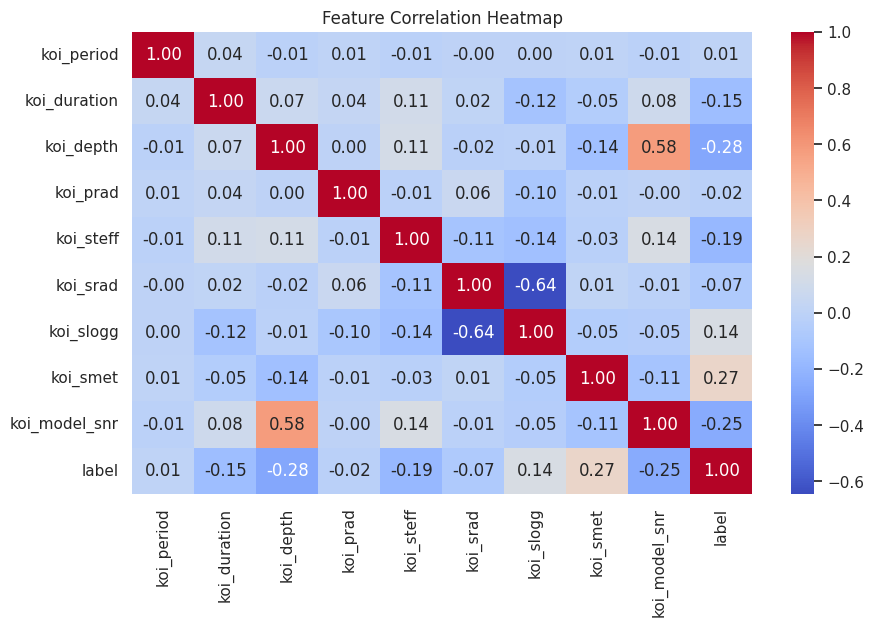

,koi_period,koi_duration,koi_depth,koi_prad,koi_steff,koi_srad,koi_slogg,koi_smet,koi_model_snr,label
0,9.488036,2.95750,615.8,2.26,5455.0,0.927,4.467,0.14,35.8,1
1,54.418383,4.50700,874.8,2.83,5455.0,0.927,4.467,0.14,25.8,1
2,19.899140,1.78220,10829.0,14.60,5853.0,0.868,4.544,-0.18,76.3,1
3,1.736952,2.40641,8079.2,33.46,5805.0,0.791,4.564,-0.52,505.6,0
4,2.525592,1.65450,603.3,2.75,6031.0,1.046,4.438,0.07,40.9,1


In [2]:
# STEP 2: PREPROCESSING & LABEL ENCODING

# Make a copy to avoid modifying original
data = df.copy()

# Convert koi_disposition to binary label
# 1 = planet (CONFIRMED or CANDIDATE), 0 = false positive
data["label"] = data["koi_disposition"].map(
    {"CONFIRMED": 1, "CANDIDATE": 1, "FALSE POSITIVE": 0}
)

# Drop rows with missing values (simple option for now)
print("Before dropping NaNs:", data.shape)
data = data.dropna()
print("After dropping NaNs:", data.shape)

# Drop the original disposition column (we now use label)
data = data.drop(columns=["koi_disposition", "kepoi_name"])

# Show class distribution
print("\n✅ Label distribution:")
print(data["label"].value_counts())

# Optional: correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Preview final dataset
data.head()


In [3]:
# install XGBoost (run this in a new cell if not installed)
!pip install xgboost scikit-learn


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import numpy as np

# STEP 3: Train/test split
X = data.drop(columns=["label"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("✅ Classification Report:")
print(classification_report(y_test, y_pred))

print("✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("✅ ROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:48:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       913
           1       0.82      0.88      0.85       923

    accuracy                           0.85      1836
   macro avg       0.85      0.85      0.85      1836
weighted avg       0.85      0.85      0.85      1836

✅ Confusion Matrix:
[[737 176]
 [107 816]]
✅ ROC-AUC Score: 0.9259


In [5]:
!pip install shap


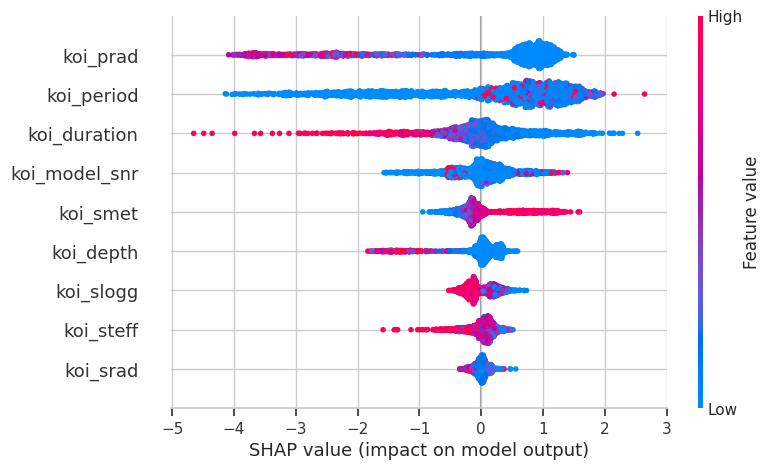

In [6]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot: global feature importance
shap.plots.beeswarm(shap_values)


In [7]:
!pip install gradio


In [8]:
import gradio as gr
import numpy as np

# Define the prediction function
def predict_planet(
    koi_period, koi_duration, koi_depth, koi_prad,
    koi_steff, koi_srad, koi_slogg, koi_smet, koi_model_snr
):
    input_array = np.array([[
        koi_period, koi_duration, koi_depth, koi_prad,
        koi_steff, koi_srad, koi_slogg, koi_smet, koi_model_snr
    ]])

    # Predict class and probability
    pred_class = model.predict(input_array)[0]
    pred_prob = model.predict_proba(input_array)[0][1]  # P(planet)

    label = "Likely Planet" if pred_class == 1 else "Likely False Positive"
    return f"{label} (P = {pred_prob:.2f})"

# Define UI inputs
inputs = [
    gr.Number(label="KOI Period (days)", value=10),
    gr.Number(label="KOI Duration (hours)", value=2.5),
    gr.Number(label="KOI Depth (ppm)", value=1000),
    gr.Number(label="KOI Radius (R⊕)", value=2.0),
    gr.Number(label="Stellar Teff (K)", value=5700),
    gr.Number(label="Stellar Radius (R☉)", value=1.0),
    gr.Number(label="Stellar log(g)", value=4.5),
    gr.Number(label="Stellar [Fe/H]", value=0.0),
    gr.Number(label="Transit SNR", value=30),
]

# Launch Gradio app
gr.Interface(
    fn=predict_planet,
    inputs=inputs,
    outputs="text",
    title="🪐 Exoplanet Classifier",
    description="Enter KOI features to predict whether it's likely a planet or a false positive."
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7f32300031a8b189b5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [9]:
import gradio as gr
import shap
import numpy as np
import matplotlib.pyplot as plt

# Redefine prediction + SHAP function
def predict_with_explanation(
    koi_period, koi_duration, koi_depth, koi_prad,
    koi_steff, koi_srad, koi_slogg, koi_smet, koi_model_snr
):
    input_data = np.array([[
        koi_period, koi_duration, koi_depth, koi_prad,
        koi_steff, koi_srad, koi_slogg, koi_smet, koi_model_snr
    ]])

    feature_names = X.columns.tolist()

    # Predict class and probability
    pred_class = model.predict(input_data)[0]
    pred_prob = model.predict_proba(input_data)[0][1]

    label = "🪐 Likely Planet" if pred_class == 1 else "🚫 Likely False Positive"
    label += f" (P = {pred_prob:.2f})"

    # SHAP explanation for this input
    explainer = shap.Explainer(model, X_train)
    shap_value = explainer(input_data)

    # Get top 3 contributing features
    contribs = sorted(
        zip(feature_names, shap_value.values[0]),
        key=lambda x: abs(x[1]), reverse=True
    )[:3]

    explanation = "\n\n**Top Contributing Features:**\n"
    for feat, val in contribs:
        direction = "↑ increases" if val > 0 else "↓ decreases"
        explanation += f"- `{feat}` → {direction} P(planet) (SHAP = {val:.3f})\n"

    # Generate SHAP bar plot
    plt.figure(figsize=(6, 3))
    shap.plots.bar(shap_value, max_display=9, show=False)
    plt.tight_layout()
    plot_path = "shap_bar.png"
    plt.savefig(plot_path)
    plt.close()

    return label + explanation, plot_path

# Gradio UI
inputs = [
    gr.Number(label="KOI Period (days)", value=10),
    gr.Number(label="KOI Duration (hours)", value=2.5),
    gr.Number(label="KOI Depth (ppm)", value=1000),
    gr.Number(label="KOI Radius (R⊕)", value=2.0),
    gr.Number(label="Stellar Teff (K)", value=5700),
    gr.Number(label="Stellar Radius (R☉)", value=1.0),
    gr.Number(label="Stellar log(g)", value=4.5),
    gr.Number(label="Stellar [Fe/H]", value=0.0),
    gr.Number(label="Transit SNR", value=30),
]

# Launch Gradio interface with SHAP explanation
gr.Interface(
    fn=predict_with_explanation,
    inputs=inputs,
    outputs=[gr.Text(label="Prediction + Explanation"), gr.Image(type="filepath")],
    title="🔭 ExoScout: AI-Powered Exoplanet Predictor",
    description="Enter KOI features to classify as planet or false positive, with SHAP-based explanation."
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1ca46d111e5d1e9001.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
